# Exploratory Data Analysis
---

In [2]:
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("clean-frc-data.csv", low_memory=False)
df.head()

,index,event_code,year,description,tournamentLevel,matchNumber,matchVideoLink,actualStartTime,autoStartTime,postResultTime,...,Red3,Red3_dq,scoreBlueAuto,scoreBlueFinal,scoreBlueFoul,scoreRedAuto,scoreRedFinal,scoreRedFoul,event_date,week
0,0,VA,2006,Qualification 1,Qualification,1,NaN,NaN,NaN,NaN,...,343.0,False,0.0,12.0,0.0,0.0,49.0,0.0,2006-03-01,1
1,1,VA,2006,Qualification 2,Qualification,2,NaN,NaN,NaN,NaN,...,1236.0,False,0.0,7.0,0.0,0.0,24.0,0.0,2006-03-01,1
2,2,VA,2006,Qualification 3,Qualification,3,NaN,NaN,NaN,NaN,...,1598.0,False,0.0,20.0,0.0,0.0,21.0,0.0,2006-03-01,1
3,3,VA,2006,Qualification 4,Qualification,4,NaN,NaN,NaN,NaN,...,612.0,False,0.0,11.0,0.0,0.0,4.0,0.0,2006-03-01,1
4,4,VA,2006,Qualification 5,Qualification,5,NaN,NaN,NaN,NaN,...,346.0,False,0.0,22.0,0.0,0.0,8.0,0.0,2006-03-01,1


## Which Alliance Wins More Matches? 

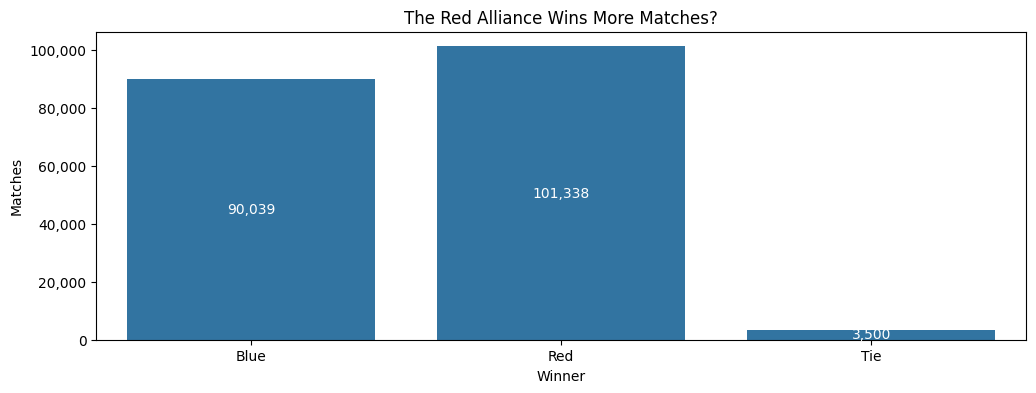

In [4]:
def who_is_the_winner(red_score, blue_score):
    """Determines which alliance should be the winner."""
    if np.isnan(red_score) or np.isnan(blue_score):
        winner = 'Error'
    elif red_score > blue_score:
        winner = 'Red'
    elif red_score < blue_score:
        winner = 'Blue'
    else:
        winner = 'Tie'
    return winner

# Determine which alliance was the winner of the match
df["Winner"] = df.apply(lambda row: who_is_the_winner(row["scoreRedFinal"], row["scoreBlueFinal"]), axis=1)
# Drop the errors from the dataset
df = df.drop(df[df.Winner == "Error"].index)
# Get the count of matches by winning alliance
viz_data = df.groupby('Winner').size().reset_index(name='Matches')
# Let's make a bar chart
plt.figure(figsize=(12,4))
graph = sns.barplot(viz_data, x='Winner', y='Matches')
# Give it a title that highlights the takeaway
graph.set_title('The Red Alliance Wins More Matches?')
# Add the actual values to the chart
graph.bar_label(graph.containers[0], fmt='{:,.0f}', label_type='center', color='white')
# Add commas to the y-axis numbers
graph.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))

## How Many Points Are Usually Scored in a Match?

Text(0.5, 1.0, 'Alliances Score 68 Points on Average')

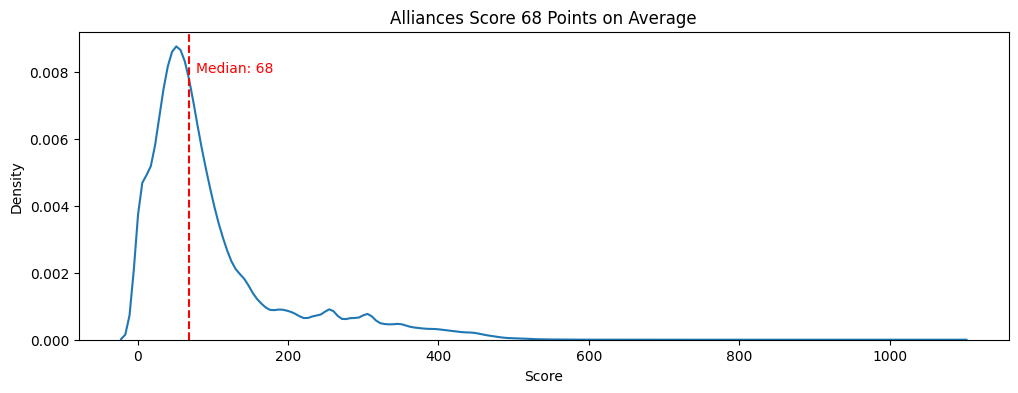

In [5]:
# Grab the final score of the red alliance and rename it to Score
viz_data = df[['scoreRedFinal']].rename({'scoreRedFinal':'Score'}, axis=1).dropna()
# Do the same thing for the blue alliance, and append it to the bottom 
viz_data = pd.concat([viz_data, df[['scoreBlueFinal']].rename({'scoreBlueFinal':'Score'}, axis=1).dropna()])
viz_data = viz_data['Score']
# Figure out what the median value is
median = int(np.median(viz_data))
# Create a distribution plot
plt.figure(figsize=(12,4))
graph = sns.kdeplot(viz_data)
# Add a red dashed line at the median
graph.axvline(median, color='r', linestyle='--')
graph.annotate(f'Median: {median}', xy=(median + 10, 0.008), xytext=(median + 10, 0.008), color='r')
# Give an informative title
graph.set_title(f'Alliances Score {median} Points on Average')

In [6]:
viz_data.describe()

count    389754.000000
mean         99.929820
std          96.356825
min           0.000000
25%          40.000000
50%          68.000000
75%         119.000000
max        1080.000000
Name: Score, dtype: float64

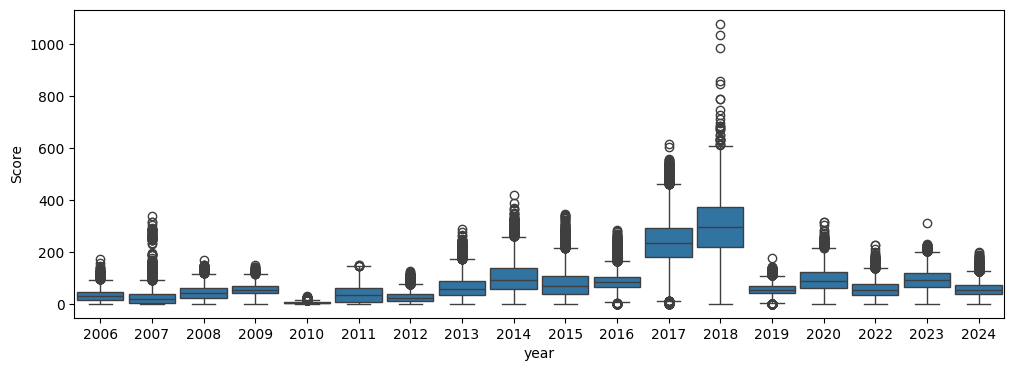

In [7]:
viz_data = df[['year', 'scoreRedFinal']].rename({'scoreRedFinal':'Score'}, axis=1).dropna()
# Do the same thing for the blue alliance, and append it to the bottom 
viz_data = pd.concat([viz_data, df[['year','scoreBlueFinal']].rename({'scoreBlueFinal':'Score'}, axis=1).dropna()])
plt.figure(figsize=(12,4))
sns.boxplot(x='year', y='Score', data=viz_data, width=0.9)
plt.show()

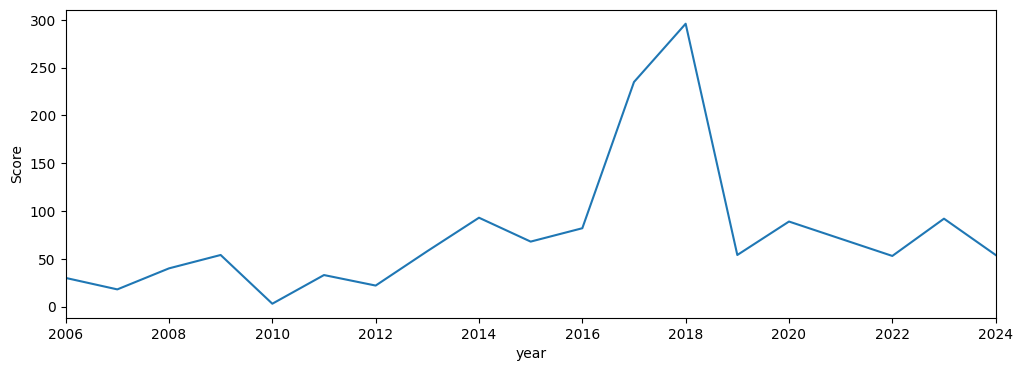

In [8]:
viz_data = df[['year', 'scoreRedFinal']].rename({'scoreRedFinal':'Score'}, axis=1).dropna()
# Do the same thing for the blue alliance, and append it to the bottom 
viz_data = pd.concat([viz_data, df[['year','scoreBlueFinal']].rename({'scoreBlueFinal':'Score'}, axis=1).dropna()])
# Get the average points scored by year
viz_data = viz_data.groupby('year')['Score'].median().reset_index()
# Create a line plot to see the tred
#fig, ax = plt.subplots()
plt.figure(figsize=(12,4))
graph = sns.lineplot(data=viz_data, x="year", y="Score")
graph.set(xlim=(viz_data['year'].min(), viz_data['year'].max()))
plt.show()

In [9]:
viz_data

,year,Score
0,2006,30.0
1,2007,18.0
2,2008,40.0
3,2009,54.0
4,2010,3.0
5,2011,33.0
6,2012,22.0
7,2013,58.0
8,2014,93.0
9,2015,68.0


## What is the Distribution of the Probability of Winning?

In [10]:
# Start clean
try:
    del(match_df)
except:
    pass

# Loop over the alliance colors
for color in ["Red", "Blue"]:
    # Loop over the positions
    for num in [1, 2, 3]:
        # This the the column we want to pull
        col  = f'{color}{num}'
        # Pull the data
        temp = df[['Winner', col, 'year']].rename({col:'Team'}, axis=1).dropna()
        # Convert to integer
        temp['Team'] = temp['Team'].astype(int)
        # Add in the alliance color
        temp['Alliance'] = [color] * len(temp.index)
        # Append this temp data to our match data.  If it doesn't exist, create it.
        try:
            match_df = pd.concat([match_df, temp.copy()])
        except:
            match_df = temp.copy()

Text(0.5, 1.0, 'Most Teams Loose the Match')

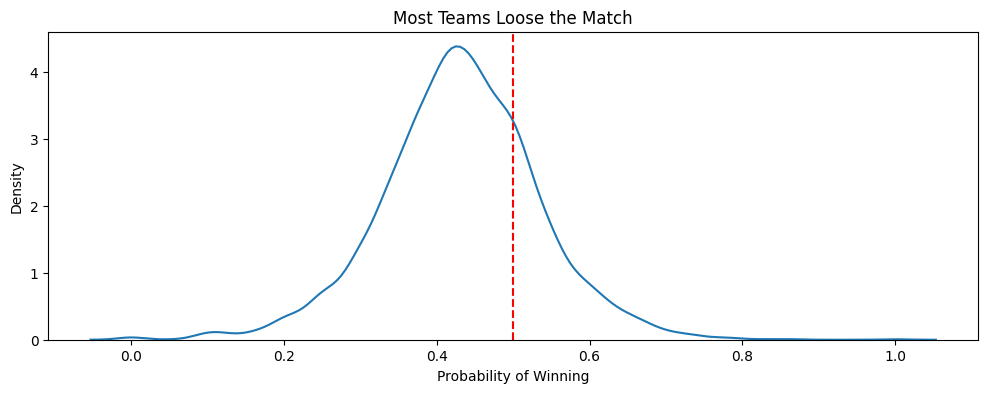

In [11]:
# Get the count of matches won by a team
wins = match_df[match_df.Alliance == match_df.Winner].groupby('Team').size().reset_index(name='Wins')
# Get the total number of matches by team and join the wins
wins = pd.merge(match_df.groupby('Team').size().reset_index(name='Matches'), wins, on='Team', how='left').fillna(0)
# Get the probability of winning a match
wins['Probability of Winning'] = wins['Wins'] / wins['Matches']
# Drop out
wins = wins[wins["Team"] < 9000]
# Select the column we want to display
viz_data = wins['Probability of Winning']
# Create a distribution plot
plt.figure(figsize=(12,4))
graph = sns.kdeplot(viz_data)
# Add a red dashed line at the median
graph.axvline(.5, color='r', linestyle='--')
# Give an informative title
graph.set_title(f'Most Teams Loose the Match')

In [12]:
wins_by_year = match_df[match_df.Alliance == match_df.Winner].groupby(['Team','year']).size().reset_index(name='Wins')
# Get the total number of matches by team and join the wins
wins_by_year = pd.merge(match_df.groupby(['Team', 'year']).size().reset_index(name='Matches'), wins_by_year, on=['Team', 'year'], how='left').fillna(0)
# Get the probability of winning a match
wins_by_year['Probability of Winning'] = wins_by_year['Wins'] / wins_by_year['Matches']
wins_by_year = wins_by_year[wins_by_year["Team"]< 9000]
wins_by_year

,Team,year,Matches,Wins,Probability of Winning
0,1,2006,36,19.0,0.527778
1,1,2007,22,11.0,0.500000
2,1,2008,38,20.0,0.526316
3,1,2009,52,30.0,0.576923
4,1,2010,60,26.0,0.433333
...,...,...,...,...,...
44709,8898,2023,10,2.0,0.200000
44710,8898,2024,10,3.0,0.300000
44711,8899,2022,26,15.0,0.576923
44712,8899,2023,24,8.0,0.333333


Text(0.5, 1.0, 'Most Teams Loose the Match')

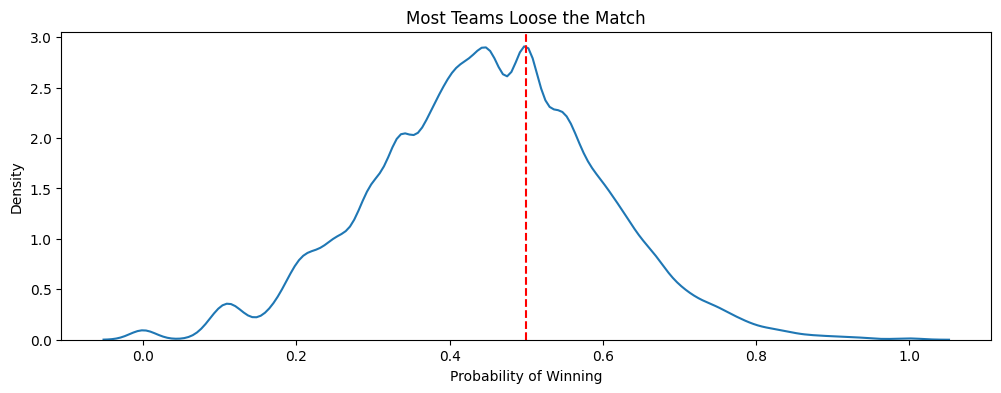

In [13]:
# Select the column we want to display
viz_data = wins_by_year['Probability of Winning']
# Create a distribution plot
plt.figure(figsize=(12,4))
graph = sns.kdeplot(viz_data)
# Add a red dashed line at the median
graph.axvline(.5, color='r', linestyle='--')
# Give an informative title
graph.set_title(f'Most Teams Loose the Match')

In [14]:
p_win = wins_by_year[["Team", "year", "Probability of Winning"]].pivot(index="Team", columns="year")
p_win

Probability of Winning                                                    \
year                   2006      2007      2008      2009      2010      2011   
Team                                                                            
1                  0.527778  0.500000  0.526316  0.576923  0.433333  0.422222   
4                  0.514286  0.382353  0.370370  0.357143  0.409091  0.347826   
5                  0.500000  0.500000  0.277778       NaN       NaN       NaN   
7                  0.625000  0.428571  0.500000  0.625000  0.285714  0.444444   
8                  0.545455  0.315789  0.480000  0.521739  0.586207  0.350000   
...                     ...       ...       ...       ...       ...       ...   
8895                    NaN       NaN       NaN       NaN       NaN       NaN   
8896                    NaN       NaN       NaN       NaN       NaN       NaN   
8897                    NaN       NaN       NaN       NaN       NaN       NaN   
8898                    NaN       NaN       NaN       NaN       NaN       NaN   
8899                    NaN       NaN       NaN       NaN       NaN       NaN   

                                                                            \
year      2012      2013      2014      2015      2016      2017      2018   
Team                                                                         
1     0.428571  0.468750  0.370370  0.465517  0.518519  0.307692  0.571429   
4     0.300000  0.526316  0.478261  0.230769  0.434783  0.473684  0.466667   
5          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
7     0.333333       NaN       NaN       NaN       NaN       NaN       NaN   
8     0.424242  0.428571  0.363636  0.300000  0.466667  0.409091  0.583333   
...        ...       ...       ...       ...       ...       ...       ...   
8895       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
8896       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
8897       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
8898       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
8899       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

                                                        
year      2019      2020      2022      2023      2024  
Team                                                    
1     0.384615       NaN  0.523810  0.586207  0.510638  
4     0.440000  0.705882  0.407407  0.471698  0.526316  
5          NaN       NaN       NaN       NaN       NaN  
7          NaN       NaN       NaN       NaN       NaN  
8     0.609756  0.875000  0.562500  0.607143  0.513514  
...        ...       ...       ...       ...       ...  
8895       NaN       NaN  0.250000  0.500000  0.458333  
8896       NaN       NaN  0.250000  0.320000  0.333333  
8897       NaN       NaN  0.250000       NaN       NaN  
8898       NaN       NaN  0.347826  0.200000  0.300000  
8899       NaN       NaN  0.576923  0.333333  0.361111  

[6544 rows x 18 columns]

In [15]:
year_over_year_p_win = []

for team in wins_by_year.Team.drop_duplicates():
    temp = wins_by_year[wins_by_year.Team == team][["year", "Probability of Winning"]]
    for year in range(temp["year"].min(), temp["year"].max()):
        try:
            x = temp[temp.year == year]["Probability of Winning"].values[0]
            y = temp[temp.year == year + 1]["Probability of Winning"].values[0]
            year_over_year_p_win.append({"x":x, "y":y, "team":team})
        except:
            continue
year_over_year_p_win = pd.DataFrame(year_over_year_p_win)

KeyboardInterrupt: 

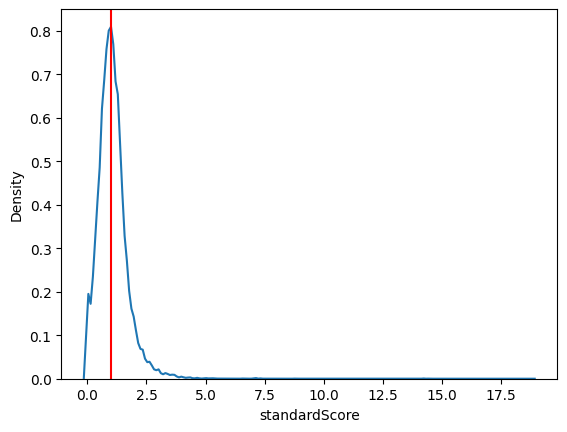

In [28]:
scores = df[['year', 'scoreRedFinal', 'Red1', 'Red2', 'Red3']].rename({'scoreRedFinal':'Score', 'Red1':'team1', 'Red2':'team2', 'Red3':'team3'}, axis=1).dropna()
# Do the same thing for the blue alliance, and append it to the bottom 
scores = pd.concat([scores, df[['year','scoreBlueFinal', 'Blue1', 'Blue2', 'Blue3']].rename({'scoreBlueFinal':'Score', 'Blue1':'team1', 'Blue2':'team2', 'Blue3':'team3'}, axis=1).dropna()])

temp = scores.groupby('year')['Score'].median().reset_index().rename({'Score':'medianScore'}, axis=1)

temp2 = pd.merge(scores, temp, on='year')

temp2['standardScore'] = temp2['Score']/temp2['medianScore']
#temp2

viz_data = temp2['standardScore']

graph = sns.kdeplot(viz_data)
graph.axvline(1, color = 'r')